# Aplicação de transformada de Fourier no processamento e interpretação de dados magnéticos

Este código utiliza a biblioteca de modelagem e inversão de dados geofísicos denominada [Fatiando a Terra](http://www.fatiando.org/index.html) para exemplificar a aplicação de transformada de Fourier (Bhattacharyya, 1967; Gunn, 1975; Blakely, 1996) ao processamento e interpretação de dados magnéticos. Neste código, o objetivo é mostrar que a aplicação da transformada de Fourier requer que os dados estejam regularmente espaçados sobre um plano.

* Bhattacharyya, B. K., 1967, Some general properties of potential fields in space and frequency domain: A review, Geoexploration, 5(3), 127-143. doi: [10.1016/0016-7142(67)90021-X](http://www.sciencedirect.com/science/article/pii/001671426790021X)

* Gunn, P. J., 1975, Linear transformations of gravity and magnetic fields, Geophysical Prospecting, 23(2), 300-312. doi: [10.1111/j.1365-2478.1975.tb01530.x](http://dx.doi.org/10.1111/j.1365-2478.1975.tb01530.x)

* Blakely, R. J., 1996, Potential theory in gravity and magnetic applications. Cambridge University Press. ISBN: 0-521-57547-8

In [1]:
%matplotlib inline
import numpy as np
from fatiando import mesher, gridder, utils
from fatiando.gravmag import sphere, prism, transform
from fatiando.vis import mpl

### Pontos onde são calculados os dados

In [2]:
shape = (60, 60) # número de dados ao longo de x e y
N = shape[0]*shape[1] # número de dados
area = [-3000, 3000, -3000, 3000] # x mínimo, x máximo, y mínimo e y máximo da área

In [3]:
xp, yp = gridder.regular(area, shape) # grade regular

In [4]:
zp = -250.*utils.gaussian2d(xp, yp, 1000., 3000., -300.0, -600.0, 30.)

In [5]:
xc = 0.5*(area[1] + area[0])
yc = 0.5*(area[3] + area[2])

dx, dy = gridder.spacing(area, shape)

In [6]:
print dx
print dy

101.694915254
101.694915254


### Campo geomagnético local

In [7]:
inc = -30. # graus
dec = 40. # graus

### Corpos sintéticos

In [8]:
incs = inc
decs = dec
amps = 3.

model = [mesher.Prism(-500., 500., -1000., 1000., 10., 1010., \
                      {'magnetization': utils.ang2vec(amps, incs, decs)})]

In [9]:
# Projeção horizontal dos corpos
projecao = []
for i, p in enumerate(model):
    projecao.append(p.get_bounds()[:4])

### Anomalia de campo total (em nT)

In [10]:
act_aprox = prism.tf(xp, yp, zp, model, inc, dec)

### Plot dos dados

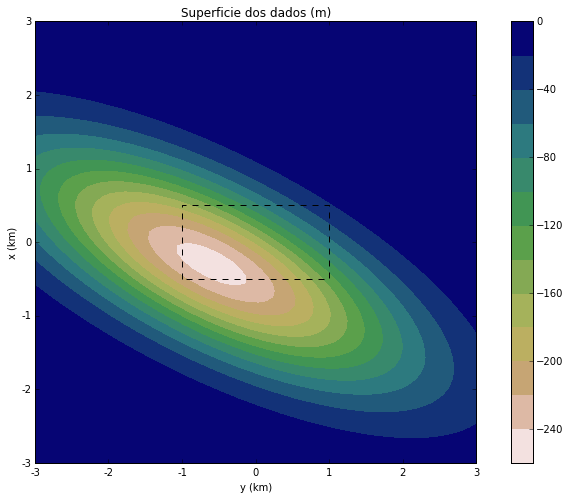

In [11]:
mpl.close('all')
mpl.figure(figsize=(10,7))

mpl.title("Superficie dos dados (m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, zp, shape, 15, cmap=mpl.get_cmap('gist_earth_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()

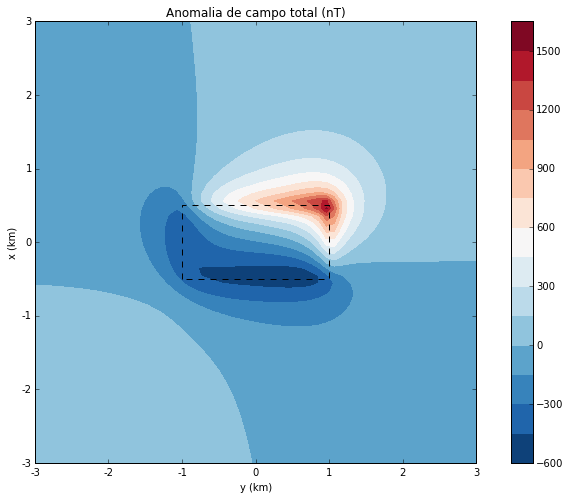

In [12]:
mpl.close('all')
mpl.figure(figsize=(10,7))

mpl.title("Anomalia de campo total (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, act_aprox, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()

### Continuação para cima

In [13]:
dado_cont_verdadeiro = prism.tf(xp, yp, np.zeros_like(zp) - 300., model, inc, dec)

In [14]:
dado_cont_calculado = transform.upcontinue(xp, yp, act_aprox, shape, 300.)

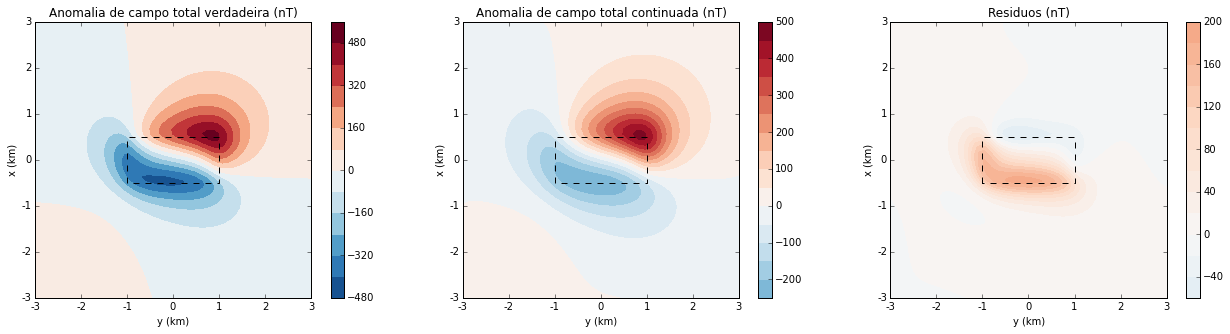

In [15]:
ranges = np.max(np.abs([np.min(dado_cont_verdadeiro), np.max(dado_cont_verdadeiro),
                        np.min(dado_cont_calculado), np.max(dado_cont_calculado)]))

mpl.close('all')
mpl.figure(figsize=(18,4.5))

mpl.subplot(1,3,1)
mpl.title("Anomalia de campo total verdadeira (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_cont_verdadeiro, shape, 15, cmap=mpl.get_cmap('RdBu_r'), 
            vmin = -ranges, vmax=ranges)
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,2)
mpl.title("Anomalia de campo total continuada (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_cont_calculado, shape, 15, cmap=mpl.get_cmap('RdBu_r'), 
            vmin = -ranges, vmax=ranges)
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,3)
mpl.title("Residuos (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_cont_calculado - dado_cont_verdadeiro, shape, 15, cmap=mpl.get_cmap('RdBu_r'), 
            vmin = -ranges, vmax=ranges)
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()

### Cálculo de derivadas

In [16]:
delta = 10.

In [17]:
dx_verdadeira = (prism.tf(xp + delta, yp, zp, model, inc, dec) - \
                 prism.tf(xp - delta, yp, zp, model, inc, dec))/ \
                 (2.*delta)
dy_verdadeira = (prism.tf(xp, yp + delta, zp, model, inc, dec) - \
                 prism.tf(xp, yp - delta, zp, model, inc, dec))/ \
                 (2.*delta)
dz_verdadeira = (prism.tf(xp, yp, zp + delta, model, inc, dec) - \
                 prism.tf(xp, yp, zp - delta, model, inc, dec))/ \
                 (2.*delta)

In [18]:
dx_calculada = transform.derivx(xp, yp, act_aprox, shape, method='fft')
dy_calculada = transform.derivy(xp, yp, act_aprox, shape, method='fft')
dz_calculada = transform.derivz(xp, yp, act_aprox, shape, method='fft')

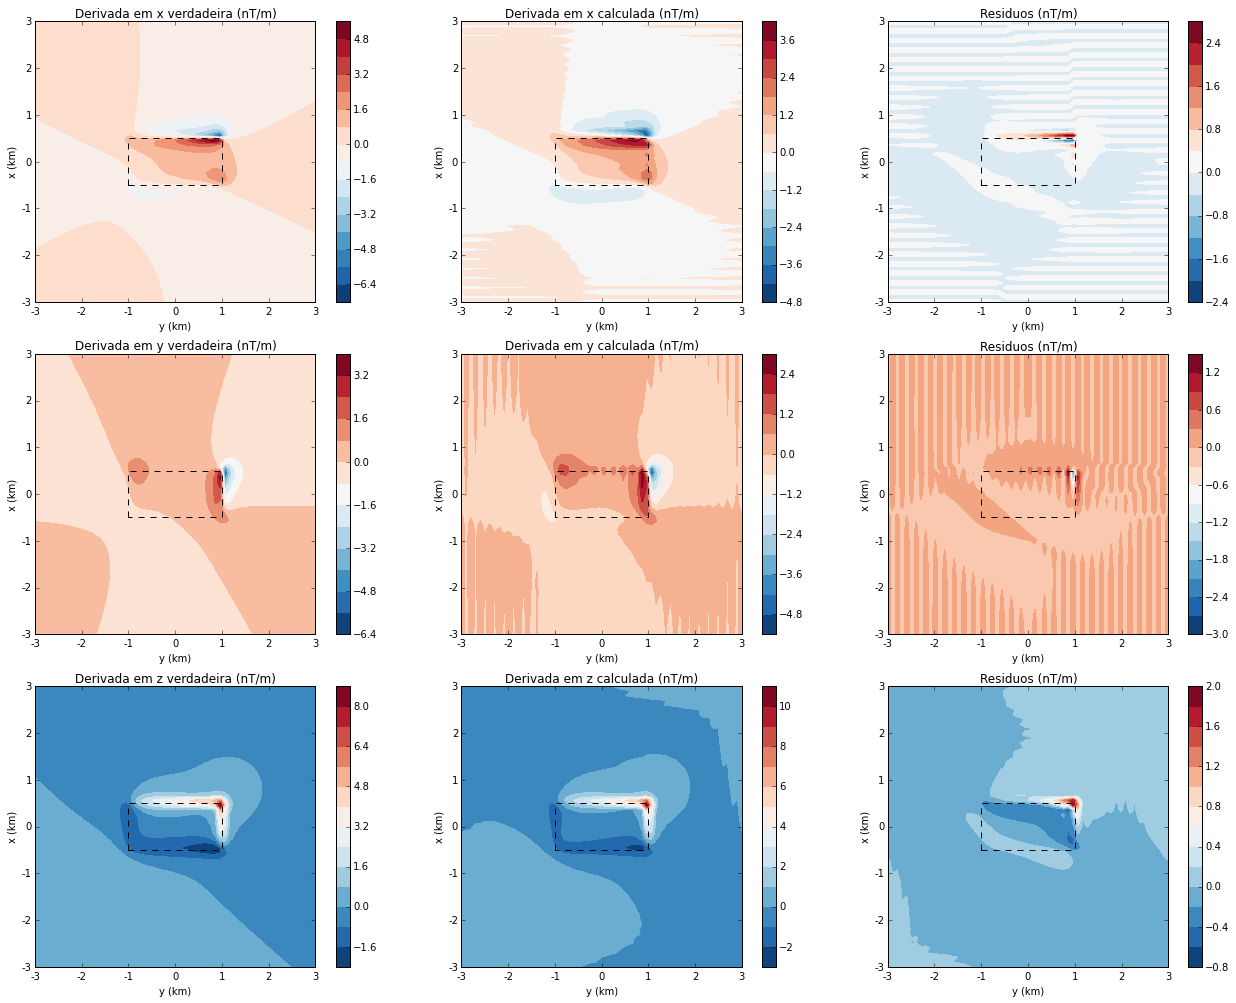

In [19]:
mpl.close('all')
mpl.figure(figsize=(18,14))

mpl.subplot(3,3,1)
mpl.title("Derivada em x verdadeira (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dx_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,2)
mpl.title("Derivada em x calculada (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dx_calculada, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,3)
mpl.title("Residuos (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dx_calculada - dx_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,4)
mpl.title("Derivada em y verdadeira (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dy_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,5)
mpl.title("Derivada em y calculada (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dy_calculada, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,6)
mpl.title("Residuos (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dy_calculada - dy_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,7)
mpl.title("Derivada em z verdadeira (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dz_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,8)
mpl.title("Derivada em z calculada (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dz_calculada, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(3,3,9)
mpl.title("Residuos (nT/m)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dz_calculada - dz_verdadeira, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()

### Redução ao polo

In [20]:
model_polo = [mesher.Prism(-500., 500., -1000., 1000., 10., 1010., \
                          {'magnetization': utils.ang2vec(amps, 90., 0.)})]

In [21]:
dado_polo_verdadeiro = prism.tf(xp, yp, zp, model_polo, 90., 0.)

In [22]:
dado_polo_calculado = transform.reduce_to_pole(xp, yp, act_aprox, shape, inc, dec, incs, decs)

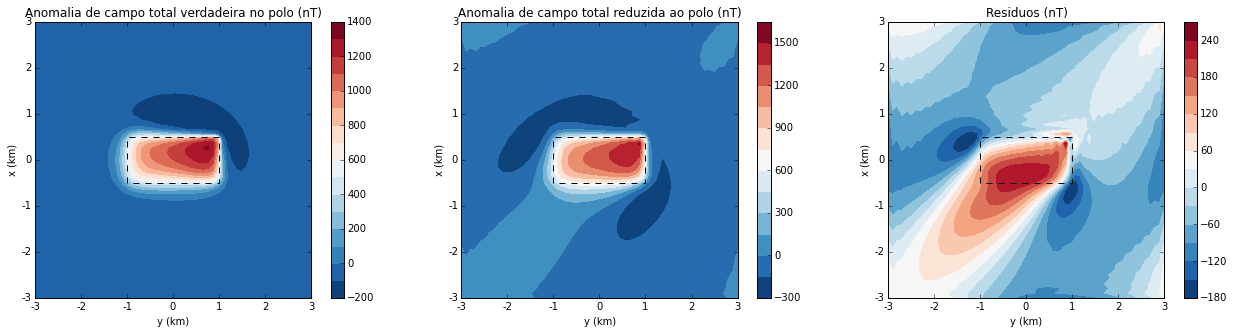

In [23]:
mpl.close('all')
mpl.figure(figsize=(18,4.5))

mpl.subplot(1,3,1)
mpl.title("Anomalia de campo total verdadeira no polo (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_polo_verdadeiro, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,2)
mpl.title("Anomalia de campo total reduzida ao polo (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_polo_calculado, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,3)
mpl.title("Residuos (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, dado_polo_calculado - dado_polo_verdadeiro, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()

### Gradiente total

In [24]:
grad_total_verdadeiro = np.sqrt(dx_verdadeira**2 + dy_verdadeira**2 + dz_verdadeira**2)

In [25]:
grad_total_calculado = np.sqrt(dx_calculada**2 + dy_calculada**2 + dz_calculada**2)

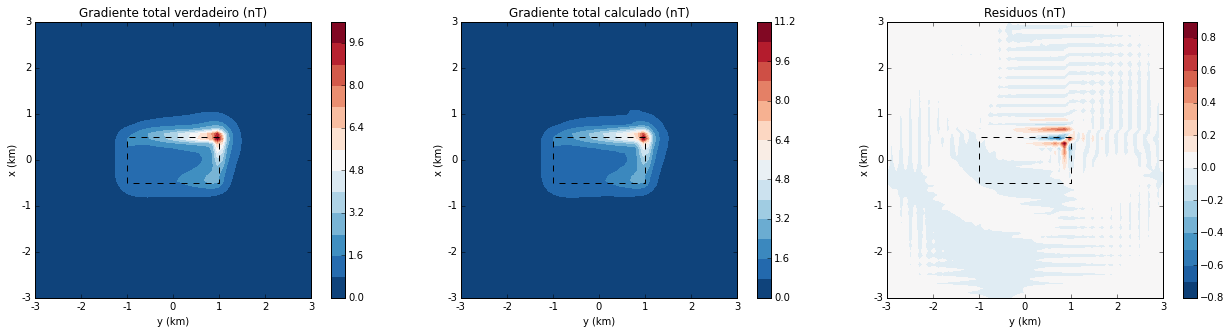

In [26]:
mpl.close('all')
mpl.figure(figsize=(18,4.5))

mpl.subplot(1,3,1)
mpl.title("Gradiente total verdadeiro (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, grad_total_verdadeiro, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,2)
mpl.title("Gradiente total calculado (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, grad_total_calculado, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.subplot(1,3,3)
mpl.title("Residuos (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, grad_total_calculado - grad_total_verdadeiro, shape, 15, cmap=mpl.get_cmap('RdBu_r'))
mpl.colorbar()
for i, sq in enumerate(projecao):
    mpl.square(sq, style='--k', linewidth=1.0, xy2ne=True)
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()

mpl.tight_layout()

mpl.show()